### Tensorflow 정리 : tf.contrib.learn을 이용한 간단한 딥러닝 구현
라이브러리 부르기
import tensorflow as tf
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split

- feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES] < 텐서플로에게 값을 제시(모든 값이 실수값을 가짐으로 표시) 및 feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES} < 텐서플로 상수 텐서 만들기
- regressor = *tf.contrib.learn.DNNRegressor*(feature_columns=feature_cols,activation_fn = tf.nn.relu, hidden_units=[256, 128, 64, 32, 16]) < 모델 부르기
- regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000) < 학습하기
- ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1) <testing_set으로 평가하기

### 이 글은 여러가지 부분으로 나뉩니다 :
1. 중요한 점 & 가능한 장치들
2. Outliers(보통을 넘어선 값들)
3. 전처리 과정
4. 연속적인 특성들에 대한 DNN 회귀
5. 예측
6. Leaky Relu의 예시
7. 연속적인 / 분류 특성들에 대한 DNN 회귀
8. 예측
9. 인공신경망
10. 결론

## 1. 중요한 점 및 가능한 디바이스들
처음에 시도시 가능한 디바이스들을 확인하는 것이 중요하다. 예를 들어 GPU에 발생하는 문제들이 종종 있기 때문이다. 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "99"

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3502651976991206377, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7335625753491988650
 physical_device_desc: "device: XLA_CPU device"]

In [3]:
from __future__ import absolute_import #파이썬 2,3버전문제로 인해 생기는 것들을 방지하고자 
from __future__ import division
from __future__ import print_function

import itertools
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib

from sklearn.model_selection import train_test_split
# 최소 최대를 0~1범위로 표준화 시키는, 전처리 과정에서 필요한 함수
from sklearn.preprocessing import MinMaxScaler

tf.logging.set_verbosity(tf.logging.INFO)
sess = tf.InteractiveSession()

train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
print('Shape of the train data with all features:', train.shape)
train = train.select_dtypes(exclude=['object'])
print("")
print('Shape of the train data with numerical features:', train.shape)
train.drop('Id',axis = 1, inplace = True)
train.fillna(0,inplace=True)

Shape of the train data with all features: (1460, 81)

Shape of the train data with numerical features: (1460, 38)


In [4]:
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
test = test.select_dtypes(exclude=['object'])

#숫자형인 것들만 남겨놓고 여기 안에서 해결하겠다는 의지

ID = test.Id
test.fillna(0,inplace=True) #결측치 임의로 0 넣기
test.drop('Id',axis = 1, inplace = True)

print("")
print("List of features contained our dataset:",list(train.columns))


List of features contained our dataset: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


### 2. Outliers : 이상치 Isolation Forest

이상치들은 [Isolation Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)를 이용하여 분리할 것이다.
>Isolation Forest는 의사결정나무를 이용하여 이상탐지를 수행하는 방법입니다. 여기서는 max_samples에서 이용할 최대 특성을 체크 후 걸러내는 방식으로 이용됩니다.
https://donghwa-kim.github.io/iforest.html

In [5]:
warnings.filterwarnings('ignore')
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 146
Number of rows without outliers: 1314


In [6]:
train.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000
5,50,85.0,14115,5,5,1993,1995,0.0,732,0,...,40,30,0,320,0,0,700,10,2009,143000
6,20,75.0,10084,8,5,2004,2005,186.0,1369,0,...,255,57,0,0,0,0,0,8,2007,307000
7,50,51.0,6120,7,5,1931,1950,0.0,0,0,...,90,0,205,0,0,0,0,4,2008,129900
8,190,50.0,7420,5,6,1939,1950,0.0,851,0,...,0,4,0,0,0,0,0,1,2008,118000
9,20,70.0,11200,5,5,1965,1965,0.0,906,0,...,0,0,0,0,0,0,0,2,2008,129500


### 3. 전처리 MinMaxScaler

Scikit-learn의 MinMaxScaler를 이용하여 0과 1사이가 되도록 우리의 데이터를 다시 정리합니다.

In [7]:
col_train = list(train.columns)
col_train_bis = list(train.columns)

# 예측해야 할 값은 처리할 필요 없으므로 제거
col_train_bis.remove('SalePrice')

mat_train = np.matrix(train)
mat_test  = np.matrix(test)
mat_new = np.matrix(train.drop('SalePrice',axis = 1))
mat_y = np.array(train.SalePrice).reshape((1314,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.235294,0.207668,0.062802,0.625,0.428571,0.953488,0.883333,0.12250,0.416274,0.0,...,0.000000,0.167582,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,0.403057
1,0.000000,0.255591,0.072904,0.500,0.857143,0.744186,0.433333,0.00000,0.576651,0.0,...,0.404891,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,0.340220
2,0.235294,0.217252,0.087396,0.625,0.428571,0.937984,0.866667,0.10125,0.286557,0.0,...,0.000000,0.115385,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,0.437966
3,0.294118,0.191693,0.072464,0.625,0.428571,0.271318,0.333333,0.00000,0.127358,0.0,...,0.000000,0.096154,0.824242,0.0,0.0,0.0,0.0,0.090909,0.00,0.243639
4,0.235294,0.268371,0.113835,0.750,0.428571,0.930233,0.833333,0.21875,0.386203,0.0,...,0.260870,0.230769,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,0.499638


Tensorflow를 이용하기 이해서는 특별한 형식으로 우리의 데이터들을 바꿔야 합니다. 우리는 연속적인 특성들만 있는 것에 따라 tf.contrib.layers.real_valued_column 이라는 함수를 먼저 사용할 것입니다. 더 많은 정보는 여기서 : https://www.tensorflow.org/api_docs/python/tf/contrib/layers/real_valued_column

tf.contrib.layer.real_valued_column : 모든 값이 실수값임을 지정

In [8]:
# List of features
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "SalePrice"

# Columns for tensorflow : 텐서플로에게 column값들을 제시
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]

# Training set and Prediction set with the features to predict : 무엇을 학습해야 하는지 input, output 값 주기
training_set = train[COLUMNS]
prediction_set = train.SalePrice

# Train and Test : train 안에서 분리하기 (x_train > training_set, x_test > testing_set)
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)
training_set.head()

# Training for submission
training_sub = training_set[col_train]

In [9]:
# Same thing but for the test set : 나중에 test에도 실행되기 위해서 따로 test 셋도 처리하기
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True)
testing_set.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
1232,0.235294,0.239617,0.074221,0.625,0.571429,0.914729,0.800000,0.00000,0.574882,0.0,...,0.343750,0.467033,0.0,0.0,0.0,0.0,0.000000,0.454545,0.00,0.556191
76,0.352941,0.000000,0.063505,0.625,0.428571,0.891473,0.766667,0.01375,0.000000,0.0,...,0.163043,0.197802,0.0,0.0,0.0,0.0,0.045161,0.363636,0.75,0.309966
962,0.235294,0.249201,0.091349,0.500,0.571429,0.682171,0.300000,0.00000,0.175708,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.363636,0.75,0.276221
433,0.294118,0.159744,0.010540,0.625,0.857143,0.271318,0.916667,0.00000,0.176297,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.454545,0.75,0.278548
1110,0.294118,0.306709,0.103927,0.375,0.428571,0.263566,0.000000,0.00000,0.000000,0.0,...,0.275815,0.109890,0.0,0.0,0.0,0.0,0.000000,0.545455,0.00,0.241049


### 4. 연속적인 특성들에 대한 깊은 인공신경망

tf.contrib.learn은 깊은 인공신경망을 실행하기 위한 가장 좋은 방법이다. 우리의 경우에는 200,100,50,25,12의 각각의 유닛들을 가진 5개의 Hidden Layer를 가질 것입니다. + 활성함수는 relu가 될 것입니다. 
우리의 경우에 이용한 최적화는 Adagrad(기본값)입니다.

In [10]:
# Model  설정하기 
tf.logging.set_verbosity(tf.logging.ERROR)
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[256, 128, 64, 32, 16])
#optimizer = tf.train.GradientDescentOptimizer( learning_rate= 0.1 ))
    
# Reset the index of training : 인덱스 정리하기
training_set.reset_index(drop = True, inplace =True)

In [11]:
#
def input_fn(data_set, pred = False):
    
    if pred == False:
        
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        labels = tf.constant(data_set[LABEL].values)
        
        return feature_cols, labels

    if pred == True:
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        
        return feature_cols

In [12]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7f233eb55668>, 'hidden_units': [256, 128, 64, 32, 16], 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(col

In [13]:
# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

In [14]:
# Display the score on the testing set
# 0.002X in average
loss_score1 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score1))

Final Loss on the testing set: 0.002432


In [15]:
# Predictions
y = regressor.predict(input_fn=lambda: input_fn(testing_set))
predictions = list(itertools.islice(y, testing_set.shape[0]))

### 5. 연속적인 특성들 + Leaky Relu를 적용한 인공신경망
우리는 다른 활성함수 : Leaky Relu 를 이용할 것입니다.
Leaky Relu의 함수는 Max(x, delta * x)인데 우리의 경우 delta = 0.01

In [16]:
def leaky_relu(x):
    return tf.nn.relu(x) - 0.01 * tf.nn.relu(-x)

In [17]:
# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = leaky_relu, hidden_units=[256, 128, 64, 32, 16])
    
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)
# Display the score on the testing set
# 0.002X in average
loss_score2 = ev["loss"]
print("Final Loss on the testing set with Leaky Relu: {0:f}".format(loss_score2))

# Predictions
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))

Final Loss on the testing set with Leaky Relu: 0.002360


In [18]:
# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.elu, hidden_units=[200, 100, 50, 25, 12])
    
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

loss_score3 = ev["loss"]

In [19]:
print("Final Loss on the testing set with Elu: {0:f}".format(loss_score3))
# Predictions
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))

Final Loss on the testing set with Elu: 0.002225


우리는 지금까지 3가지 다른 활성함수로 3가지 제출을 내었습니다. 이것은 단지 연속적인 특성을 이용하여 만든 것인데요, 범주형 특성을 더하면 도다른 모델을 만들어보겠습니다.

### 6. 연속형, 범주형 특성 모두 이용한 인공 신경망
범주형 특성을 더하므로 같은 함수를 반복해야 합니다.

In [20]:
# Import and split : 저번과 동일한 방식
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
train.drop('Id',axis = 1, inplace = True)
train_numerical = train.select_dtypes(exclude=['object'])
train_numerical.fillna(0,inplace = True)

train_categoric = train.select_dtypes(include=['object'])
train_categoric.fillna('NONE',inplace = True) #numerical과 다르게 적용
train = train_numerical.merge(train_categoric, left_index = True, right_index = True) 

#test셋도 동일하게 적용
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
ID = test.Id
test.drop('Id',axis = 1, inplace = True)
test_numerical = test.select_dtypes(exclude=['object'])
test_numerical.fillna(0,inplace = True)

test_categoric = test.select_dtypes(include=['object'])
test_categoric.fillna('NONE',inplace = True) #numerical과 다르게 적용

test = test_numerical.merge(test_categoric, left_index = True, right_index = True) 

In [21]:
# Removie the outliers: 저번과 동일한 방식
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train_numerical)
y_noano = clf.predict(train_numerical)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train_numerical = train_numerical.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_numerical.reset_index(drop = True, inplace = True)

train_categoric = train_categoric.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_categoric.reset_index(drop = True, inplace = True)

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)

In [22]:
#Preprocessing
col_train_num = list(train_numerical.columns)
col_train_num_bis = list(train_numerical.columns)

col_train_cat = list(train_categoric.columns)

col_train_num_bis.remove('SalePrice')

mat_train = np.matrix(train_numerical)
mat_test  = np.matrix(test_numerical)
mat_new = np.matrix(train_numerical.drop('SalePrice',axis = 1))
mat_y = np.array(train.SalePrice)

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y.reshape(1314,1))

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train_num_scale = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test_num_scale  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

In [23]:
train[col_train_num] = pd.DataFrame(prepro.transform(mat_train),columns = col_train_num)
test[col_train_num_bis]  = test_num_scale

In [24]:
# Model 적용
COLUMNS = col_train_num
FEATURES = col_train_num_bis
LABEL = "SalePrice"

FEATURES_CAT = col_train_cat

engineered_features = []

for continuous_feature in FEATURES:
    engineered_features.append(
        tf.contrib.layers.real_valued_column(continuous_feature))

for categorical_feature in FEATURES_CAT:
    sparse_column = tf.contrib.layers.sparse_column_with_hash_bucket(
        categorical_feature, hash_bucket_size=1000)

    engineered_features.append(tf.contrib.layers.embedding_column(sparse_id_column=sparse_column, dimension=16,combiner="sum"))
                                 
# Training set and Prediction set with the features to predict
training_set = train[FEATURES + FEATURES_CAT]
prediction_set = train.SalePrice

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES + FEATURES_CAT] ,
                                                    prediction_set, test_size=0.20, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES + FEATURES_CAT).merge(y_train, left_index = True, right_index = True)

# 제출하기
training_sub = training_set[FEATURES + FEATURES_CAT]
testing_sub = test[FEATURES + FEATURES_CAT]

In [25]:
# Same thing but for the test set
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES + FEATURES_CAT).merge(y_test, left_index = True, right_index = True)

In [26]:
training_set[FEATURES_CAT] = training_set[FEATURES_CAT].applymap(str)
testing_set[FEATURES_CAT] = testing_set[FEATURES_CAT].applymap(str)

def input_fn_new(data_set, training = True):
    continuous_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
    
    categorical_cols = {k: tf.SparseTensor(
        indices=[[i, 0] for i in range(data_set[k].size)], values = data_set[k].values, dense_shape = [data_set[k].size, 1]) for k in FEATURES_CAT}

    # Merges the two dictionaries into one.
    feature_cols = dict(list(continuous_cols.items()) + list(categorical_cols.items()))
    
    if training == True:
        # Converts the label column into a constant Tensor.
        label = tf.constant(data_set[LABEL].values)

        # Returns the feature columns and the label.
        return feature_cols, label
    
    return feature_cols

# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn =leaky_relu, hidden_units=[256, 128, 64, 32, 16])


In [27]:
categorical_cols = {k: tf.SparseTensor(indices=[[i, 0] for i in range(training_set[k].size)], values = training_set[k].values, dense_shape = [training_set[k].size, 1]) for k in FEATURES_CAT}

In [28]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn = lambda: input_fn_new(training_set) , steps=2000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7f232e5a2400>, 'hidden_units': [256, 128, 64, 32, 16], 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(col

In [29]:
ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1)
loss_score4 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score4))

Final Loss on the testing set: 0.001835


### 7. 얕은 신경망
여기서는 하나의 Hidden Layer에 여러개의 유닛들이 포함되어있는 구조를 볼 것입니다. 일단 1000개 정도로 실험해 보자.

In [30]:
# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn = tf.nn.relu, hidden_units=[2500])

In [31]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn = lambda: input_fn_new(training_set) , steps=2000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7f232cfb0be0>, 'hidden_units': [2500], 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='MasVnr

In [32]:
ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1)
loss_score5 = ev["loss"]

In [33]:
print("Final Loss on the testing set: {0:f}".format(loss_score5))

Final Loss on the testing set: 0.001501


### 8. 결론

In [34]:
list_score = [loss_score1, loss_score2, loss_score3, loss_score4,loss_score5]
list_model = ['Relu_cont', 'LRelu_cont', 'Elu_cont', 'Relu_cont_categ','Shallow_1ku']

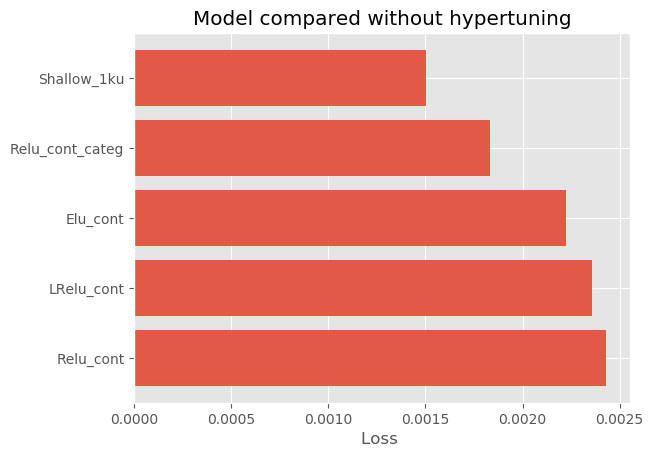

In [35]:
import matplotlib.pyplot as plt; plt.rcdefaults()

plt.style.use('ggplot')
objects = list_model
y_pos = np.arange(len(objects))
performance = list_score
 
plt.barh(y_pos, performance, align='center', alpha=0.9)
plt.yticks(y_pos, objects)
plt.xlabel('Loss ')
plt.title('Model compared without hypertuning')
 
plt.show()

### The best solution must be

In [36]:
def to_submit(pred_y,name_out):
    y_predict = list(itertools.islice(pred_y, test.shape[0]))
    y_predict = pd.DataFrame(prepro_y.inverse_transform(np.array(y_predict).reshape(len(y_predict),1)), columns = ['SalePrice'])
    y_predict = y_predict.join(ID)
    y_predict.to_csv(name_out + '.csv',index=False)

In [37]:
y_predict = regressor.predict(input_fn=lambda: input_fn_new(testing_sub, training = False))    
to_submit(y_predict, "submission_shallow")

#### Special Thanks to [Neural Network Model for House Prices](https://www.kaggle.com/zoupet/neural-network-model-for-house-prices-tensorflow).
#### 이 글은 [Neural Network Model for House Prices](https://www.kaggle.com/zoupet/neural-network-model-for-house-prices-tensorflow)을 참고한 커널입니다.